In [3]:
import sys
 
sys.path.insert(0, "../")

from EnsembleFramework import Framework

In [4]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

dataset_name = 'Cora'
split = "public"
dataset = Planetoid(root='../data', name=dataset_name, split=split)
dataset.transform = T.NormalizeFeatures()

features =  dataset[0].x
y =  dataset[0].y

test =  dataset[0].test_mask
train = dataset[0].train_mask
val =  dataset[0].val_mask

edge_index = dataset[0].edge_index 
edge_index = add_self_loops(edge_index)[0]

In [8]:
import torch
from torch.nn.functional import normalize
def user_function(kwargs):
    return normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2, dim =1)


hops_list = [0, 2,3,4,5,6,7,8,9,10,15]
framework = Framework([user_function for i in hops_list], 
                     hops_list=hops_list, ## to obtain best for local neighborhood
                     clfs=[],
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=[{'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None} for i in hops_list])
{'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}
new_features = framework.get_features(features, edge_index,torch.ones_like(y).type(torch.bool))#train

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:146: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


In [9]:
new_features[0].shape

torch.Size([2708, 1433])

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

scores = []
eu_scores = []
sparsities = []
for i, hop_features in enumerate(new_features):
    print(f"Hop {hops_list[i]}")
    sparsity = round(((hop_features == 0).sum()*100 / hop_features.numel()).item(), 2)
    sparsities.append(sparsity)
    print(f"Sparsity {sparsity} %")
    score = silhouette_score(hop_features.cpu(), y, metric="cosine")
    eu_score = silhouette_score(hop_features.cpu(), y)
    scores.append(score)
    eu_scores.append(eu_score)

Hop 0
Sparsity 98.73 %
Hop 2
Sparsity 86.16 %
Hop 3
Sparsity 67.93 %
Hop 4
Sparsity 46.08 %
Hop 5
Sparsity 28.2 %
Hop 6
Sparsity 17.65 %
Hop 7
Sparsity 12.76 %
Hop 8
Sparsity 10.64 %
Hop 9
Sparsity 9.62 %
Hop 10
Sparsity 9.17 %
Hop 15
Sparsity 8.89 %


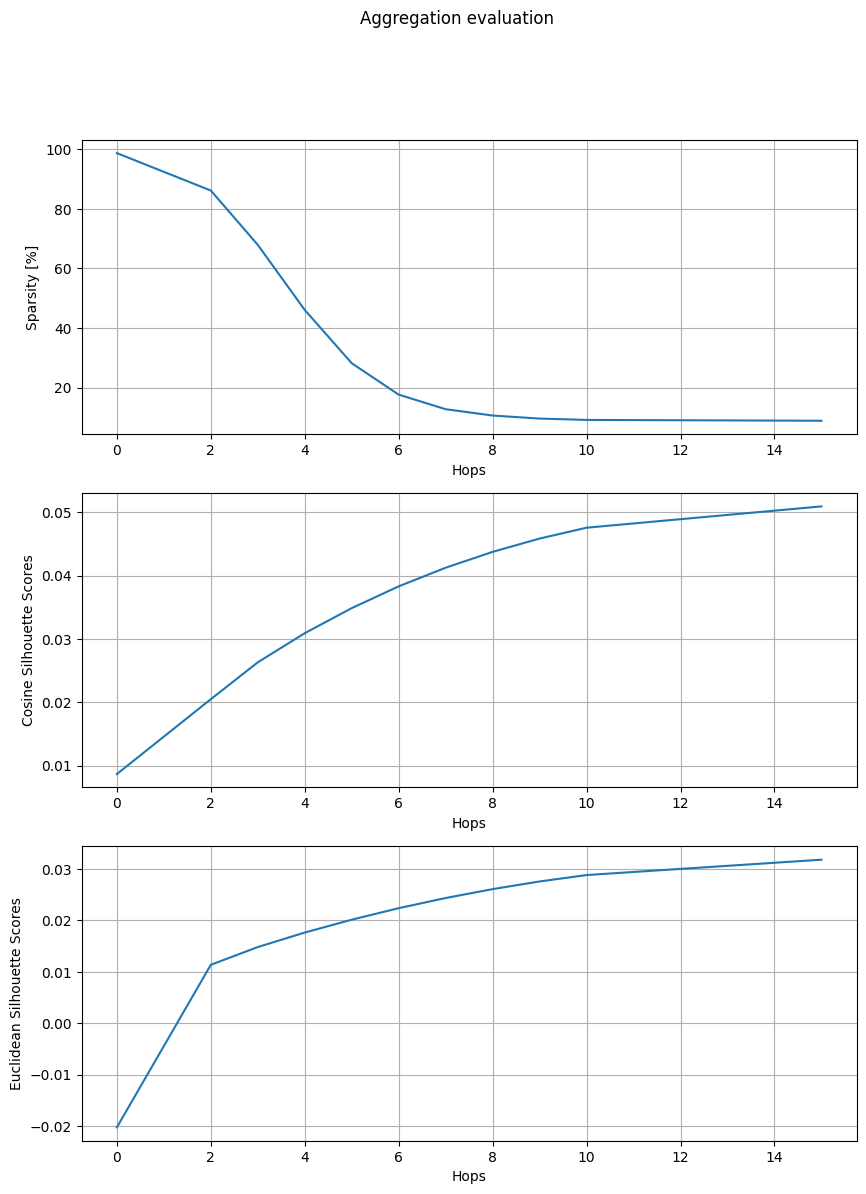

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figheight(13)
fig.set_figwidth(10)
fig.suptitle('Aggregation evaluation')

ax1.plot(hops_list, sparsities)
ax1.set_xlabel("Hops")
ax1.set_ylabel("Sparsity [%]")
ax1.grid()

ax2.plot(hops_list, scores)
ax2.set_xlabel("Hops")
ax2.set_ylabel("Cosine Silhouette Scores")
ax2.grid()

ax3.plot(hops_list, eu_scores)
ax3.set_xlabel("Hops")
ax3.set_ylabel("Euclidean Silhouette Scores")
ax3.grid()

In [13]:
from torch.nn.functional import cosine_similarity
a = torch.tensor([[-1,0]], dtype=torch.float)
b = torch.tensor([[1, 0]], dtype=torch.float)
cosine_similarity(a,b)

tensor([-1.])

## Attention threshold eval

In [22]:
import torch
import numpy as np
from torch.nn.functional import normalize
def user_function(kwargs):
    return normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2, dim =1)

# cosine_eps_list = [.5, .1, .05, .01, .005, .001, 0.0005, 0.0001]
cosine_eps_list = np.linspace(8e-3, 2e-2, 20, endpoint=True).tolist()
attn_thresholds = [{'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps': cosine_eps,
                     'dropout_attn': None} for cosine_eps in cosine_eps_list]

framework = Framework([user_function for i in attn_thresholds], 
                     hops_list=[50 for i in attn_thresholds], ## to obtain best for local neighborhood
                     clfs=[],
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=attn_thresholds)
new_features = framework.get_features(features, edge_index,torch.ones_like(y).type(torch.bool))#train

In [23]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

scores = []
eu_scores = []
sparsities = []
for i, hop_features in enumerate(new_features):
    print(f"cosine eps {cosine_eps_list[i]}")
    sparsity = round(((hop_features == 0).sum()*100 / hop_features.numel()).item(), 2)
    sparsities.append(sparsity)
    print(f"Sparsity {sparsity} %")
    score = silhouette_score(hop_features.cpu(), y, metric="cosine")
    eu_score = silhouette_score(hop_features.cpu(), y)
    scores.append(score)
    eu_scores.append(eu_score)

cosine eps 0.008
Sparsity 8.53 %
cosine eps 0.00863157894736842
Sparsity 8.6 %
cosine eps 0.009263157894736843
Sparsity 8.64 %
cosine eps 0.009894736842105263
Sparsity 8.67 %
cosine eps 0.010526315789473684
Sparsity 8.85 %
cosine eps 0.011157894736842106
Sparsity 8.89 %
cosine eps 0.011789473684210527
Sparsity 8.89 %
cosine eps 0.012421052631578947
Sparsity 8.89 %
cosine eps 0.013052631578947368
Sparsity 8.89 %
cosine eps 0.01368421052631579
Sparsity 8.89 %
cosine eps 0.01431578947368421
Sparsity 8.96 %
cosine eps 0.014947368421052633
Sparsity 9.0 %
cosine eps 0.015578947368421053
Sparsity 9.0 %
cosine eps 0.016210526315789474
Sparsity 9.04 %
cosine eps 0.016842105263157894
Sparsity 9.08 %
cosine eps 0.017473684210526315
Sparsity 9.08 %
cosine eps 0.018105263157894735
Sparsity 9.11 %
cosine eps 0.018736842105263156
Sparsity 9.11 %
cosine eps 0.01936842105263158
Sparsity 9.11 %
cosine eps 0.02
Sparsity 9.15 %


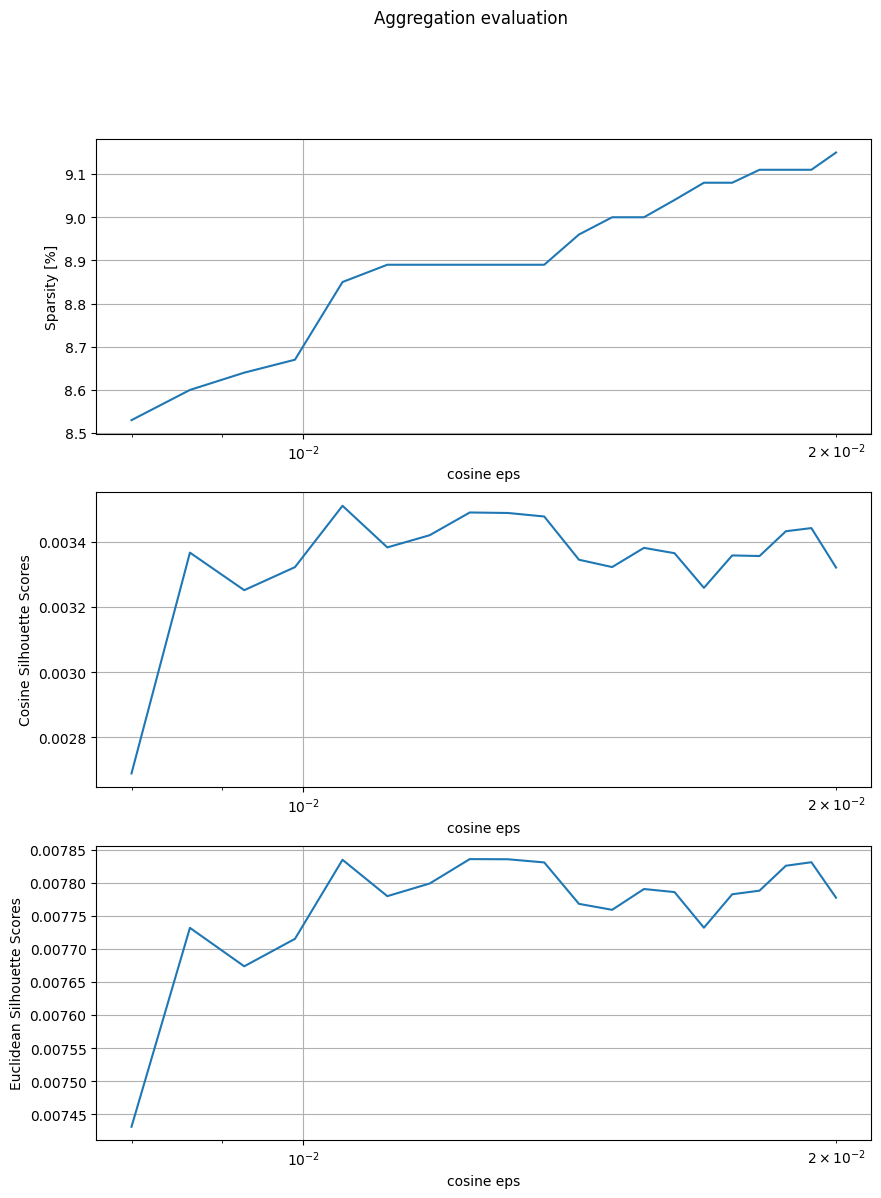

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figheight(13)
fig.set_figwidth(10)
fig.suptitle('Aggregation evaluation')

ax1.semilogx(cosine_eps_list, sparsities)
ax1.set_xlabel("cosine eps")
ax1.set_ylabel("Sparsity [%]")
ax1.grid()

ax2.semilogx(cosine_eps_list, scores)
ax2.set_xlabel("cosine eps")
ax2.set_ylabel("Cosine Silhouette Scores")
ax2.grid()

ax3.semilogx(cosine_eps_list, eu_scores)
ax3.set_xlabel("cosine eps")
ax3.set_ylabel("Euclidean Silhouette Scores")
ax3.grid()

In [32]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
METRIC = "cosine"
hops_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]

space = {
    'inter_layer_normalize': [True, False],
    'use_pseudo_attention': [True],
    'cosine_eps': np.linspace(5e-3, 5e-1, 10),
    'dropout': np.linspace(0, 1e-3, 10)
}
hops_to_best_configs = dict({})
hops_to_best_score = dict({})

for hop in tqdm(hops_list):
    print("Create Hyperparam space")
    param_grid = ParameterGrid(space)
    attn_thresholds = []
    for params in param_grid.__iter__():
        attn_thresholds.append({'inter_layer_normalize': params["inter_layer_normalize"],
                         'use_pseudo_attention':params["use_pseudo_attention"],
                         'cosine_eps': params["cosine_eps"],
                         'dropout_attn': params["dropout"]})
    print("Create features")
    framework = Framework([user_function for i in attn_thresholds], 
                     hops_list=[hop for i in attn_thresholds], ## to obtain best for local neighborhood
                     clfs=[],
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=attn_thresholds)
    new_features = framework.get_features(features, edge_index,torch.ones_like(y).type(torch.bool))

    print("Create scores")
    scores = []
    for i, hop_features in enumerate(new_features):
        score = silhouette_score(hop_features.cpu(), y, metric=METRIC)
        scores.append(score)
    hops_to_best_configs[hop] = attn_thresholds[np.argmax(scores)]
    hops_to_best_score[hop] = scores[np.argmax(scores)]

  0%|          | 0/16 [00:00<?, ?it/s]

Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores
Create Hyperparam space
Create features
Create scores


In [34]:
hops_to_best_configs

{0: {'inter_layer_normalize': True,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.0},
 1: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.0},
 2: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.00011111111111111112},
 3: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.00022222222222222223},
 4: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.0},
 5: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.0},
 6: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.0003333333333333334},
 7: {'inter_layer_normalize': False,
  'use_pseudo_attention': True,
  'cosine_eps': 0.005,
  'dropout_attn': 0.0},
 8: {'inter_layer

In [29]:
attn_thresholds[np.argmax(scores)]

{'inter_layer_normalize': False,
 'use_pseudo_attention': True,
 'cosine_eps': 0.06,
 'dropout_attn': 0.002}

In [30]:
scores[np.argmax(scores)]

0.03850261